# modelint with XGBoost regressor

## 0. Needed libraries

In [1]:
import _my_path
import xgboost as xgb
from sklearn.datasets import load_boston
from modelint.xgbparser import TreeEnsemble

In [2]:
%matplotlib inline

## 1. Load data and train model

We use the Boston House Prices dataset

In [3]:
boston = load_boston()
print(boston.DESCR[:1280])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

We train an XGBoost regression model...

In [4]:
dtrain = xgb.DMatrix(data=boston.data,
                     label=boston.target,
                     feature_names=boston.feature_names)
params = {'objective': 'reg:linear', 
          'base_score': 0.,
          'max_depth': 4, 
          'eta': 0.5, 
          'gamma': 1.,
          'alpha': 1., 
          'lambda': 50.,
          'min_child_weight': 4,
          'subsample': 0.9,
          'colsample_bylevel': 0.3}
bst = xgb.train(params, dtrain, num_boost_round=100)

...and dump it as a text file

In [5]:
bst.dump_model('xgb_dump.txt', with_stats=True)

In [6]:
!head 'xgb_dump.txt'

booster[0]:
0:[CRIM<15.718] yes=1,no=2,missing=1,gain=831.614,cover=458
	1:leaf=10.3049,cover=433
	2:leaf=1.694,cover=25
booster[1]:
0:[PTRATIO<19.9] yes=1,no=2,missing=1,gain=2013,cover=461
	1:leaf=6.77008,cover=273
	2:[INDUS<24.815] yes=3,no=4,missing=3,gain=32.3987,cover=188
		3:leaf=3.01455,cover=183
		4:leaf=0.104324,cover=5


## 2. Interpret prediction

Load model

In [7]:
interpreter = TreeEnsemble(feat_map=boston.feature_names, 
                           base_score=params['base_score']) # careful to add the correct base_score !
interpreter.load_dump('xgb_dump.txt')

We chose a sample to predict

In [8]:
!head xgb_dump.txt

booster[0]:
0:[CRIM<15.718] yes=1,no=2,missing=1,gain=831.614,cover=458
	1:leaf=10.3049,cover=433
	2:leaf=1.694,cover=25
booster[1]:
0:[PTRATIO<19.9] yes=1,no=2,missing=1,gain=2013,cover=461
	1:leaf=6.77008,cover=273
	2:[INDUS<24.815] yes=3,no=4,missing=3,gain=32.3987,cover=188
		3:leaf=3.01455,cover=183
		4:leaf=0.104324,cover=5


In [9]:
TO_PREDICT = 161
x = boston.data[TO_PREDICT].ravel()

We plot the importance of each features

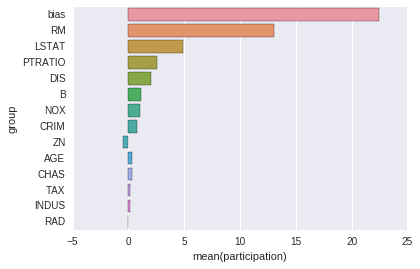

In [10]:
interpreter.plot_parts(x)

Note that we can get the numeric version :

In [11]:
pred, features_parts, bias = interpreter.predict(x)

In [12]:
part_feats = [(abs(p), p, f) for p, f in zip(features_parts, boston.feature_names)]
part_feats.sort(reverse=True)

print('Feature\t\tParticipation')
print('-------\t\t-------------')
print('{}\t\t{}{:.1f}'.format('bias', '+' if bias else '', bias))
for _, p, f in part_feats:
    if p >= 0.:
        sign = '+'
    else:
        sign = ''
    print('{}\t\t{}{:2.1f}'.format(f, sign, p))
print('-------\t\t-------------')
print('prediction =\t{:.1f}'.format(pred))

Feature		Participation
-------		-------------
bias		+22.4
RM		+13.1
LSTAT		+4.9
PTRATIO		+2.6
DIS		+2.0
B		+1.1
NOX		+1.0
CRIM		+0.8
ZN		-0.5
AGE		+0.4
CHAS		+0.4
TAX		+0.1
INDUS		+0.1
RAD		-0.0
-------		-------------
prediction =	48.4
